## Notebook for experiments on Oxford Newer College LIDAR dataset 

In [6]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from pioneer.das.api.platform import Platform
from scipy.spatial.transform import Rotation as R
from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp 
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 180 seconds


### Load ground truth data -- specified as accurate within 1cm

#### sec, nsec, x, y, z, qx, qy, qz, qw


In [2]:
dir_name = "/media/derm/06EF-127D3/Newer College Dataset/"
experiment_name = "01_short_experiment-20230331T172433Z-009/01_short_experiment/"
fn_gt = dir_name + experiment_name + "ground_truth/registered_poses.csv"
# print(fn_gt)

#sec,nsec,x,y,z,qx,qy,qz,qw
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
# print(np.shape(gt))
print(gt[20,:])

[ 1.58383659e+09  1.82838528e+08 -3.35320000e+00  8.23849000e+00
  1.40965000e-01  4.06383000e-03  3.68173000e-03 -6.05930000e-01
  7.95499000e-01]


### Load  point clouds

In [3]:
import open3d as o3d
from os import listdir
scan_dir = dir_name + experiment_name + "raw_format/ouster_zip_files/ouster_scan-007/ouster_scan/"
list_of_all_scans = sorted(listdir(scan_dir))
# print(scan_dir)
# print(len(list_of_all_scans))

idx = 100
scan1_fn = scan_dir + str(list_of_all_scans[idx])
print(scan1_fn)
pc1 = o3d.io.read_point_cloud(scan1_fn)
pc1 = np.asarray(pc1.points)  

scan2_fn = scan_dir + str(list_of_all_scans[idx+1])
print(scan2_fn)
pc2 = o3d.io.read_point_cloud(scan2_fn)
pc2 = np.asarray(pc2.points)  

/media/derm/06EF-127D3/Newer College Dataset/01_short_experiment-20230331T172433Z-009/01_short_experiment/raw_format/ouster_zip_files/ouster_scan-007/ouster_scan/cloud_1583836684_980269824.pcd
/media/derm/06EF-127D3/Newer College Dataset/01_short_experiment-20230331T172433Z-009/01_short_experiment/raw_format/ouster_zip_files/ouster_scan-007/ouster_scan/cloud_1583836685_581422848.pcd


In [4]:
it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 10, 
           draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
print("\n predicted standard deviations of error: \n", it.pred_stds)
ViewInteractiveWidget(it.plt.window)

2023-06-06 11:14:08.038033: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


iter 0


2023-06-06 11:14:09.751249: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-06 11:14:09.819799: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7874dd0


iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9

 estimated solution vector X: 
 tf.Tensor([-0.29566    -0.49616507 -0.02703261  0.00167048  0.03305888 -0.07627756], shape=(6,), dtype=float32)


/home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/vtkmodules/util/numpy_support.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _vtk_np = {vtkConstants.VTK_BIT:numpy.bool,



 predicted standard deviations of error: 
 tf.Tensor(
[6.2607252e-04 8.5430645e-04 2.1553962e-04 2.2924462e-05 3.6663521e-05
 7.0642091e-05], shape=(6,), dtype=float32)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

<IPython.core.display.Javascript object>


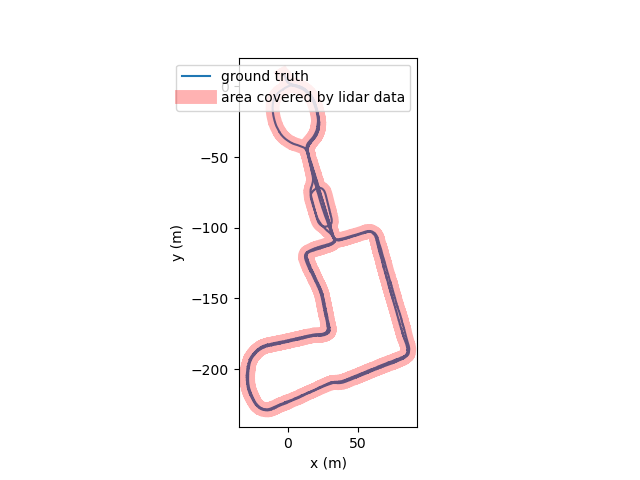

In [5]:
#plot ground truth trajectory
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.plot(gt[:,2], gt[:,3], label = "ground truth")

#superimpose trajectory from <short_experiment_01>
first_timestamp = int(list_of_all_scans[0][6:16])
last_timestamp = int(list_of_all_scans[-1][6:16]) #scrape timestamp from name of velodyne .pcl file

# print(first_timestamp)
# print(last_timestamp)
first_idx = np.argwhere(gt[:,0] == first_timestamp)[0][0]
last_idx = np.argwhere(gt[:,0] == last_timestamp)[0][0]
# print(last_idx)
ax.plot(gt[first_idx:last_idx,2], gt[first_idx:last_idx,3], 'r', lw = 10, alpha = 0.3, label = 'area covered by lidar data')
ax.legend(loc = 'best')

In [ ]:
#iteratively run through clouds and generate trajectory
runlen = 100
x_hist = np.zeros([runlen, 6])

for idx in range(runlen):
    print("~~~~~~~~~~ iter: ", idx, "~~~~~~~~~~~~~~")
    
    scan1_fn = scan_dir + str(list_of_all_scans[idx])
#     print(scan1_fn)
    pc1 = o3d.io.read_point_cloud(scan1_fn)
    pc1 = np.asarray(pc1.points)  

    scan2_fn = scan_dir + str(list_of_all_scans[idx+1])
#     print(scan2_fn)
    pc2 = o3d.io.read_point_cloud(scan2_fn)
    pc2 = np.asarray(pc2.points) 
    
    it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 10, 
           draw = False, group = 2, RM = False, DNN_filter = False)
    x_hist[idx] = it.X

In [ ]:
fig, ax = plt.subplots()
ax.plot(x_hist[:,0])
ax.plot(np.diff(gt[::10,2]))

## Main Goal:  05 - Quad with Dynamics
https://www.youtube.com/watch?v=sAmaJlql-vs

In [ ]:
idx = 1000
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx) + ".npy"
pc1 = np.load(fn1)
fn2 = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/point_clouds/frame_" + str(idx + 1) + ".npy"
pc2 = np.load(fn2)

it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 10, 
           draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
print("\n predicted standard deviations of error: \n", it.pred_stds)
ViewInteractiveWidget(it.plt.window)

## Stretch Goal: get point cloud registration algorithm to work in 06-Dynamic Spinning test
https://www.youtube.com/watch?v=9K-ljJt5mVY 

In [ ]:
idx = 140 #245
fn1 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx) + ".npy"
pc1 = np.load(fn1)
fn2 = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/point_clouds/frame_" + str(idx + 1) + ".npy"
pc2 = np.load(fn2)

it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 10, 
           draw = True, group = 2, RM = False, DNN_filter = False)#, x0 = initial_guess)
print("\n predicted standard deviations of error: \n", it.pred_stds)
ViewInteractiveWidget(it.plt.window)

In [ ]:
gt_fn = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"
# sec, nsec, x, y, z, qx, qy, qz, qw
gt = np.loadtxt(gt_fn, delimiter=',',skiprows = 1)
print(gt[idx])

In [ ]:
fig, ax = plt.subplots()

ax.plot(gt[920:950,2], gt[920:950,3])

## Debug multiplying quaternions

In [ ]:
from scipy.spatial.transform import Rotation as R

# a = R.from_euler('xyz', [0.1,0,0]).as_quat()
# b = R.from_euler('xyz', [0.1,0,0]).as_quat()

# a = R.from_euler('xyz', [0.,0,0]).as_rotvec()
# b = R.from_euler('xyz', [0.,0,10]).as_rotvec()

a = R.from_euler('xyz', [0,   -0.5,  -0.1])
b = R.from_euler('xyz', [0.4583, -1.1846,  -0.6786])

c = b * a
# print(a, b)
# print(c)
print(c.as_euler('xyz'))
# print(R.from_quat(c).as_euler('xyz'))